In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.rcParams["figure.figsize"] = (20,20)

plt.ion()   # interactive mode

### Load the data of ants & bees

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-05-24 16:33:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.166.17, 13.224.166.129, 13.224.166.66, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.166.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  33.6MB/s    in 1.3s    

2020-05-24 16:33:14 (33.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!ls -ltr 

total 46188
-rw-r--r-- 1 root root 47286322 Mar 15  2017 hymenoptera_data.zip
drwxr-xr-x 1 root root     4096 May 13 16:29 sample_data


In [4]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [5]:
!ls -ltr 

total 46192
drwxr-xr-x 4 root root     4096 Mar 13  2017 hymenoptera_data
-rw-r--r-- 1 root root 47286322 Mar 15  2017 hymenoptera_data.zip
drwxr-xr-x 1 root root     4096 May 13 16:29 sample_data


### Data augmentation

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data visualization

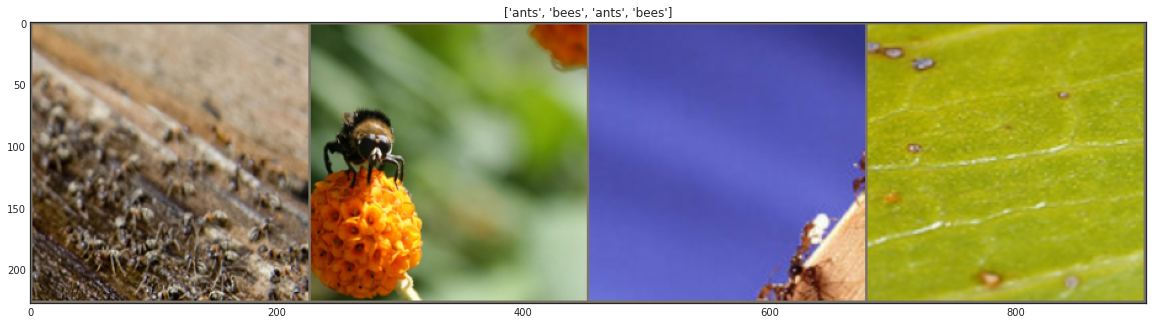

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    with plt.style.context('seaborn-white'): 
         plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetune the convnet 

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


### Train & evaluate the downloaded model

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6535 Acc: 0.6803
val Loss: 0.2178 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5472 Acc: 0.7787
val Loss: 0.2829 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5353 Acc: 0.8115
val Loss: 0.3127 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4791 Acc: 0.8156
val Loss: 0.3573 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5163 Acc: 0.8033
val Loss: 0.6108 Acc: 0.7843

Epoch 5/24
----------
train Loss: 0.9269 Acc: 0.7377
val Loss: 0.5099 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5075 Acc: 0.7992
val Loss: 0.3282 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4444 Acc: 0.8238
val Loss: 0.2536 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3932 Acc: 0.8238
val Loss: 0.2062 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2919 Acc: 0.8934
val Loss: 0.2019 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3329 Acc: 0.8730
val Loss: 0.2207 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3103 Acc: 0.8730
val Loss: 0.1822 Acc: 0.9085

Ep

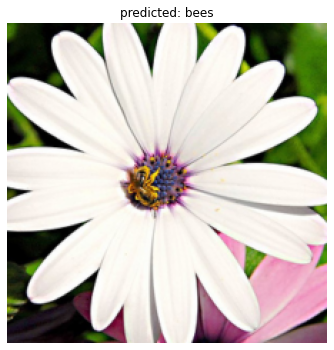

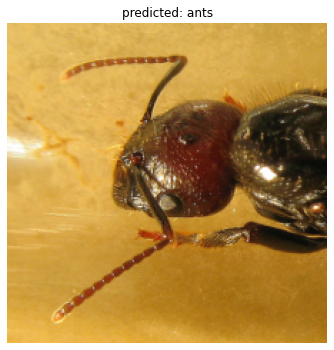

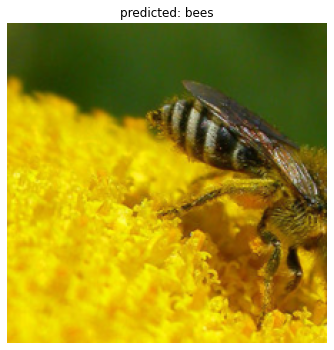

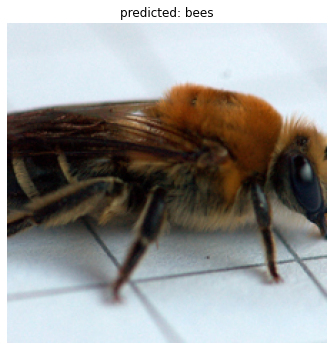

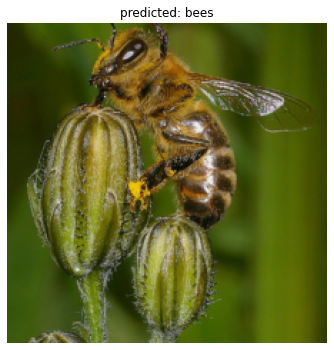

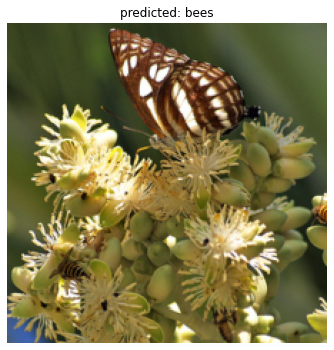

In [17]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [21]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_conv.state_dict():
    print(param_tensor, "\t", model_conv.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

### Train & evaluate

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5872 Acc: 0.6721
val Loss: 0.2088 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.5582 Acc: 0.7500
val Loss: 0.1608 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4867 Acc: 0.7787
val Loss: 0.2083 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4319 Acc: 0.8279
val Loss: 0.1481 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3705 Acc: 0.8238
val Loss: 0.1553 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4475 Acc: 0.8443
val Loss: 0.1435 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4065 Acc: 0.8279
val Loss: 0.1848 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3056 Acc: 0.8730
val Loss: 0.1817 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3721 Acc: 0.8402
val Loss: 0.2099 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3536 Acc: 0.8238
val Loss: 0.1756 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3060 Acc: 0.8689
val Loss: 0.1610 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3560 Acc: 0.8525
val Loss: 0.1565 Acc: 0.9477

Ep

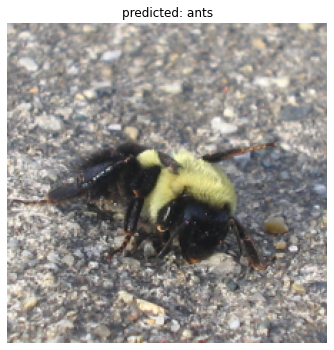

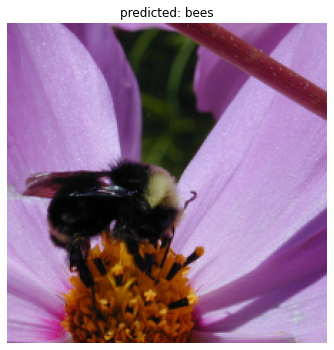

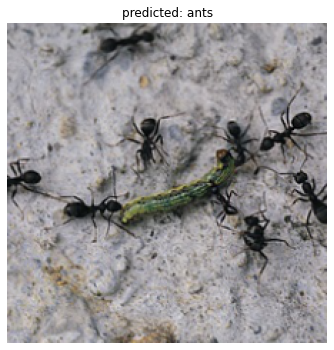

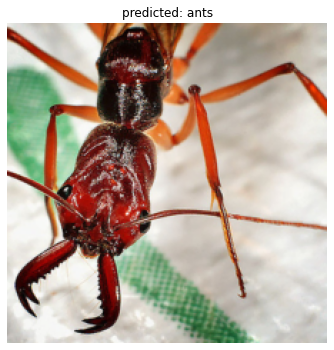

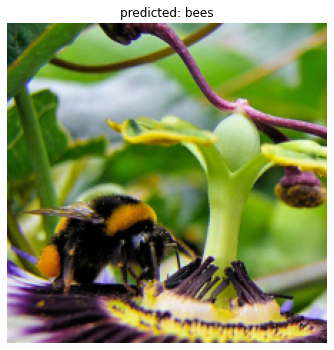

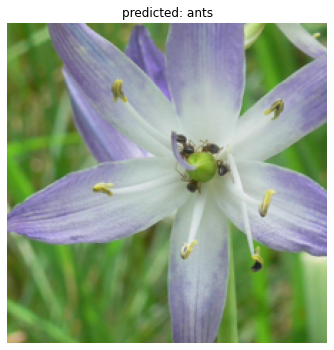

In [22]:
visualize_model(model_conv)

plt.ioff()
plt.show()